Annotation file loaded: visa_dataset/candle/image_anno.csv
                                image   label mask
0  candle/Data/Images/Normal/0000.JPG  normal  NaN
1  candle/Data/Images/Normal/0001.JPG  normal  NaN
2  candle/Data/Images/Normal/0002.JPG  normal  NaN
3  candle/Data/Images/Normal/0003.JPG  normal  NaN
4  candle/Data/Images/Normal/0004.JPG  normal  NaN
Normal images: 1000
Anomaly images: 100


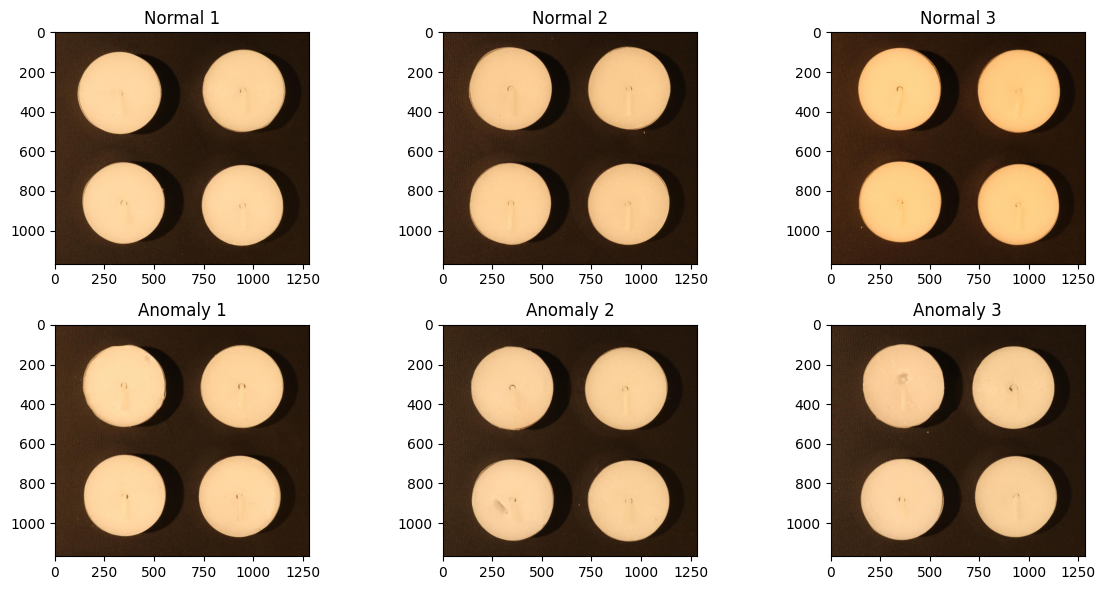

In [2]:
import os
import pandas as pd
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Set paths
base_dir = "visa_dataset"
category = "candle"  # Change this to work with different categories

# Define paths
category_dir = os.path.join(base_dir, category)
images_dir = os.path.join(category_dir, "Data", "Images")
normal_dir = os.path.join(images_dir, "Normal")
anomaly_dir = os.path.join(images_dir, "Anomaly")
anno_file = os.path.join(category_dir, "image_anno.csv")

# Check if annotation file exists
if os.path.exists(anno_file):
    anno_df = pd.read_csv(anno_file)
    print(f"Annotation file loaded: {anno_file}")
    print(anno_df.head())
else:
    print(f"Annotation file not found: {anno_file}")

# Count images
normal_images = os.listdir(normal_dir)
anomaly_images = os.listdir(anomaly_dir)
print(f"Normal images: {len(normal_images)}")
print(f"Anomaly images: {len(anomaly_images)}")

# Display some sample images
plt.figure(figsize=(12, 6))
for i, img_file in enumerate(normal_images[:3]):
    plt.subplot(2, 3, i+1)
    img = Image.open(os.path.join(normal_dir, img_file))
    plt.imshow(img)
    plt.title(f"Normal {i+1}")

for i, img_file in enumerate(anomaly_images[:3]):
    plt.subplot(2, 3, i+4)
    img = Image.open(os.path.join(anomaly_dir, img_file))
    plt.imshow(img)
    plt.title(f"Anomaly {i+1}")

plt.tight_layout()
plt.show()

In [4]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import time

def manual_grader(category_name, num_samples=None):
    """
    Tool to manually grade images from Normal and Anomaly sets one at a time
    Returns a DataFrame with image paths and grades
    
    Parameters:
    - category_name: The subfolder in VisA dataset (e.g., "candle")
    - num_samples: Number of samples to grade from each category
                  If None, will grade up to 100 from each category
    """
    # Paths
    normal_path = os.path.join(base_dir, category_name, "Data", "Images", "Normal")
    anomaly_path = os.path.join(base_dir, category_name, "Data", "Images", "Anomaly")
    
    # Sample images
    normal_files = os.listdir(normal_path)
    anomaly_files = os.listdir(anomaly_path)
    
    # Determine sample size
    if num_samples is None:
        normal_samples = normal_files[:min(100, len(normal_files))]
        anomaly_samples = anomaly_files[:min(100, len(anomaly_files))]
    else:
        # Select random samples if specific number requested
        np.random.seed(42)
        normal_samples = np.random.choice(normal_files, min(num_samples, len(normal_files)), replace=False)
        anomaly_samples = np.random.choice(anomaly_files, min(num_samples, len(anomaly_files)), replace=False)
    
    # Create dataframe to store grades
    graded_data = []
    
    # Create widgets that will be reused
    image_output = widgets.Output()
    slider = widgets.IntSlider(value=50, min=0, max=100, description='Grade (0-100):')
    submit_button = widgets.Button(description="Submit Grade")
    status_output = widgets.Output()
    progress_output = widgets.Output()
    
    # Counter for total images
    total_images = len(normal_samples) + len(anomaly_samples)
    current_image = 0
    
    # Combined list of images to grade
    all_images = [(os.path.join(normal_path, img), "Normal") for img in normal_samples] + \
                 [(os.path.join(anomaly_path, img), "Anomaly") for img in anomaly_samples]
    
    # Display widgets
    display(image_output)
    display(slider)
    display(submit_button)
    display(status_output)
    display(progress_output)
    
    def grade_next_image():
        nonlocal current_image
        
        # Check if we've graded all images
        if current_image >= len(all_images):
            with status_output:
                clear_output(wait=True)
                print("All images have been graded!")
                
                # Convert to DataFrame
                graded_df = pd.DataFrame(graded_data)
                
                # Save to CSV
                output_file = f"{category_name}_manual_grades.csv"
                graded_df.to_csv(output_file, index=False)
                print(f"Grades saved to {output_file}")
            return
        
        # Get current image
        img_path, img_type = all_images[current_image]
        
        # Update progress
        with progress_output:
            clear_output(wait=True)
            print(f"Progress: {current_image+1}/{total_images} ({(current_image+1)/total_images*100:.1f}%)")
            print(f"Current set: {img_type}")
        
        # Display image
        with image_output:
            clear_output(wait=True)
            img = Image.open(img_path)
            plt.figure(figsize=(8, 8))
            plt.imshow(img)
            plt.title(f"Image Type: {img_type}\nImage {current_image+1} of {total_images}")
            plt.axis('off')
            plt.show()
        
        # Reset slider to middle value for each new image
        slider.value = 50 if img_type == "Anomaly" else 90
    
    def on_button_click(b):
        nonlocal current_image
        
        img_path, img_type = all_images[current_image]
        grade = slider.value
        
        with status_output:
            clear_output(wait=True)
            print(f"Grade submitted: {grade} for image {current_image+1}/{total_images}")
        
        # Store result
        graded_data.append({
            'image_path': img_path,
            'category': 1 if img_type == "Normal" else 0,  # 1 for normal, 0 for anomaly
            'grade': grade
        })
        
        # Move to next image
        current_image += 1
        
        # Display next image after a short delay
        time.sleep(0.5)  # Give user a moment to see the confirmation
        grade_next_image()
    
    # Set up button callback
    submit_button.on_click(on_button_click)
    
    # Start with the first image
    grade_next_image()
    
    # Return the DataFrame when all images are graded
    return pd.DataFrame(graded_data) if graded_data else None

# Example usage:
grades_df = manual_grader("candle")  # Grade up to 100 images from each category
# grades_df = manual_grader("candle", num_samples=10)  # Grade 10 from each category

Output()

IntSlider(value=50, description='Grade (0-100):')

Button(description='Submit Grade', style=ButtonStyle())

Output()

Output()

Auto-grading 100 normal images...
Auto-grading 100 anomaly images...
Auto-graded 200 images
Grades saved to candle_auto_grades.csv

Grade summary:
Normal images: Mean grade = 87.7
Anomaly images: Mean grade = 35.5


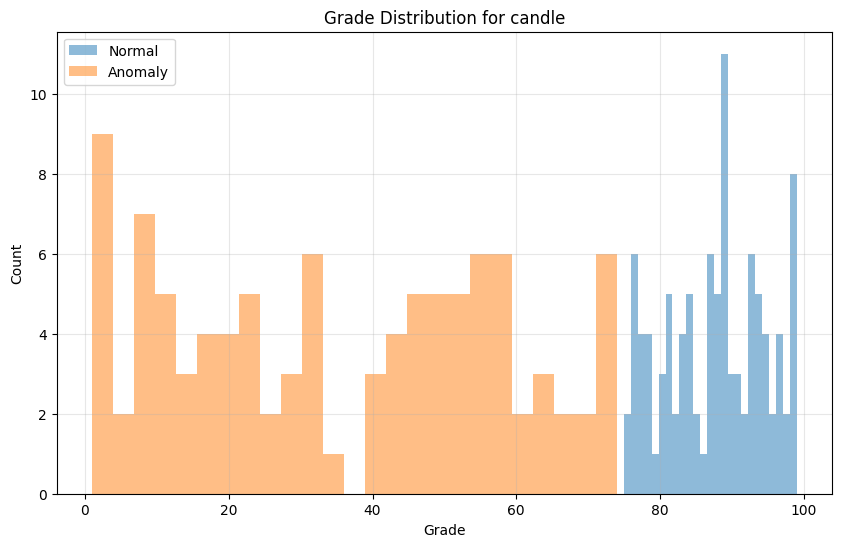

In [3]:
def auto_grader(category_name, num_samples=None):
    """
    Tool to automatically grade images with random scores
    - Normal images: random scores between 75-99
    - Anomaly images: random scores between 1-75
    
    Parameters:
    - category_name: The subfolder in VisA dataset (e.g., "candle")
    - num_samples: Number of samples to grade from each category
                  If None, will grade up to 100 from each category
    
    Returns:
    - DataFrame with image paths, categories, and grades
    """
    # Paths
    normal_path = os.path.join(base_dir, category_name, "Data", "Images", "Normal")
    anomaly_path = os.path.join(base_dir, category_name, "Data", "Images", "Anomaly")
    
    # Get image files
    normal_files = os.listdir(normal_path)
    anomaly_files = os.listdir(anomaly_path)
    
    # Determine sample size
    if num_samples is None:
        normal_samples = normal_files[:min(100, len(normal_files))]
        anomaly_samples = anomaly_files[:min(100, len(anomaly_files))]
    else:
        # Select random samples if specific number requested
        np.random.seed(42)
        normal_samples = np.random.choice(normal_files, min(num_samples, len(normal_files)), replace=False)
        anomaly_samples = np.random.choice(anomaly_files, min(num_samples, len(anomaly_files)), replace=False)
    
    # Create dataframe to store grades
    graded_data = []
    
    # Grade normal images (75-99 range)
    print(f"Auto-grading {len(normal_samples)} normal images...")
    for img_file in normal_samples:
        img_path = os.path.join(normal_path, img_file)
        grade = np.random.randint(75, 100)  # Random integer between 75-99
        
        graded_data.append({
            'image_path': img_path,
            'category': 1,  # 1 for normal
            'grade': grade
        })
    
    # Grade anomaly images (1-75 range)
    print(f"Auto-grading {len(anomaly_samples)} anomaly images...")
    for img_file in anomaly_samples:
        img_path = os.path.join(anomaly_path, img_file)
        grade = np.random.randint(1, 76)  # Random integer between 1-75
        
        graded_data.append({
            'image_path': img_path,
            'category': 0,  # 0 for anomaly
            'grade': grade
        })
    
    # Convert to DataFrame
    graded_df = pd.DataFrame(graded_data)
    
    # Save to CSV
    output_file = f"{category_name}_auto_grades.csv"
    graded_df.to_csv(output_file, index=False)
    print(f"Auto-graded {len(graded_data)} images")
    print(f"Grades saved to {output_file}")
    
    # Summary statistics
    print("\nGrade summary:")
    print(f"Normal images: Mean grade = {graded_df[graded_df['category']==1]['grade'].mean():.1f}")
    print(f"Anomaly images: Mean grade = {graded_df[graded_df['category']==0]['grade'].mean():.1f}")
    
    # Plot grade distributions
    plt.figure(figsize=(10, 6))
    plt.hist(graded_df[graded_df['category']==1]['grade'], bins=25, alpha=0.5, label='Normal')
    plt.hist(graded_df[graded_df['category']==0]['grade'], bins=25, alpha=0.5, label='Anomaly')
    plt.xlabel('Grade')
    plt.ylabel('Count')
    plt.title(f'Grade Distribution for {category_name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig(f"{category_name}_grade_distribution.png")
    plt.show()
    
    return graded_df

# Example usage:
auto_grades_df = auto_grader("candle")  # Grade up to 100 images from each category
# auto_grades_df = auto_grader("candle", num_samples=50)  # Grade 50 from each category

In [5]:
auto_grades_df.head()

,image_path,category,grade
0,visa_dataset/candle/Data/Images/Normal/0071.JPG,1,93
1,visa_dataset/candle/Data/Images/Normal/0717.JPG,1,93
2,visa_dataset/candle/Data/Images/Normal/0703.JPG,1,80
3,visa_dataset/candle/Data/Images/Normal/0065.JPG,1,98
4,visa_dataset/candle/Data/Images/Normal/0059.JPG,1,97


In [4]:
class VisAGradedDataset(Dataset):
    def __init__(self, grades_df, transform=None):
        self.data = grades_df
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        category = self.data.iloc[idx]['category']  # 1 for normal, 0 for anomaly
        grade = self.data.iloc[idx]['grade'] / 100.0  # Normalize to 0-1
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, category, grade

# Example usage (after you've created grades_df):
transform = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
#dataset = VisAGradedDataset(auto_grades_df, transform=transform)

In [5]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class MultiTaskModel(nn.Module):
    def __init__(self, pretrained=True):
        super(MultiTaskModel, self).__init__()
        
        # Load pre-trained EfficientNet
        self.backbone = models.efficientnet_b0(pretrained=pretrained)
        
        # Get the number of features in the last layer
        backbone_output_features = self.backbone.classifier[1].in_features
        
        # Remove the classification layer
        self.backbone.classifier = nn.Identity()
        
        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(backbone_output_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Classification head for good/bad
        self.classification_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),  # Binary output
            nn.Sigmoid()  # For binary classification
        )
        
        # Regression head for score
        self.regression_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)  # Single score output
        )
    
    def forward(self, x):
        # Extract features from backbone
        features = self.backbone(x)
        
        # Shared representation
        shared_features = self.shared(features)
        
        # Get predictions from each head
        classification = self.classification_head(shared_features)
        regression = self.regression_head(shared_features)
        
        return classification, regression
    
def freeze_backbone(model):
    """
    Freeze all backbone parameters, only train the custom heads
    """
    # Freeze all backbone parameters
    for param in model.backbone.parameters():
        param.requires_grad = False
    
    # Verify our custom heads are still trainable
    for param in model.shared.parameters():
        assert param.requires_grad == True
    
    for param in model.classification_head.parameters():
        assert param.requires_grad == True
        
    for param in model.regression_head.parameters():
        assert param.requires_grad == True
    
    return model


In [5]:
def train_multitask_model(model, train_loader, val_loader, num_epochs=30):
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = model.to(device)
    
    # Loss functions
    classification_criterion = nn.BCELoss()
    regression_criterion = nn.MSELoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    # Training history
    history = {
        'train_class_loss': [],
        'train_reg_loss': [],
        'train_total_loss': [],
        'val_class_loss': [],
        'val_reg_loss': [],
        'val_total_loss': []
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_class_loss = 0.0
        train_reg_loss = 0.0
        train_total_loss = 0.0
        
        for images, categories, grades in train_loader:
            # Move to device
            images = images.to(device)
            categories = categories.float().to(device).view(-1, 1)  # Shape for BCE loss
            grades = grades.float().to(device).view(-1, 1)  # Shape for MSE loss
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            class_pred, reg_pred = model(images)
            
            # Calculate losses
            class_loss = classification_criterion(class_pred, categories)
            reg_loss = regression_criterion(reg_pred, grades)
            
            # Weighted total loss (0.5 for each task)
            total_loss = 0.5 * class_loss + 0.5 * reg_loss
            
            # Backward pass and optimize
            total_loss.backward()
            optimizer.step()
            
            # Track losses
            train_class_loss += class_loss.item()
            train_reg_loss += reg_loss.item()
            train_total_loss += total_loss.item()
        
        # Calculate average losses
        train_class_loss /= len(train_loader)
        train_reg_loss /= len(train_loader)
        train_total_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        val_class_loss = 0.0
        val_reg_loss = 0.0
        val_total_loss = 0.0
        
        with torch.no_grad():
            for images, categories, grades in val_loader:
                images = images.to(device)
                categories = categories.float().to(device).view(-1, 1)
                grades = grades.float().to(device).view(-1, 1)
                
                class_pred, reg_pred = model(images)
                
                class_loss = classification_criterion(class_pred, categories)
                reg_loss = regression_criterion(reg_pred, grades)
                total_loss = 0.5 * class_loss + 0.5 * reg_loss
                
                val_class_loss += class_loss.item()
                val_reg_loss += reg_loss.item()
                val_total_loss += total_loss.item()
        
        val_class_loss /= len(val_loader)
        val_reg_loss /= len(val_loader)
        val_total_loss /= len(val_loader)
        
        # Update learning rate
        scheduler.step(val_total_loss)
        
        # Save model if validation loss improved
        if val_total_loss < best_val_loss:
            best_val_loss = val_total_loss
            torch.save(model.state_dict(), f"{category}_best_model.pth")
            print(f"Model saved at epoch {epoch+1}")
        
        # Update history
        history['train_class_loss'].append(train_class_loss)
        history['train_reg_loss'].append(train_reg_loss)
        history['train_total_loss'].append(train_total_loss)
        history['val_class_loss'].append(val_class_loss)
        history['val_reg_loss'].append(val_reg_loss)
        history['val_total_loss'].append(val_total_loss)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: [Class: {train_class_loss:.4f}, Reg: {train_reg_loss:.4f}, Total: {train_total_loss:.4f}], "
              f"Val Loss: [Class: {val_class_loss:.4f}, Reg: {val_reg_loss:.4f}, Total: {val_total_loss:.4f}]")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_class_loss'], label='Train Classification')
    plt.plot(history['val_class_loss'], label='Val Classification')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Classification Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_reg_loss'], label='Train Regression')
    plt.plot(history['val_reg_loss'], label='Val Regression')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Regression Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"{category}_training_history.png")
    plt.show()
    
    return model, history

Loaded grades from candle_auto_grades.csv
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/josasson/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


/Users/josasson/miniconda3/envs/myenv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/josasson/miniconda3/envs/myenv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20.5M/20.5M [00:00<00:00, 51.9MB/s]


Using device: mps
Model saved at epoch 1
Epoch 1/30, Train Loss: [Class: 0.6873, Reg: 0.2380, Total: 0.4627], Val Loss: [Class: 0.6880, Reg: 0.0993, Total: 0.3937]
Model saved at epoch 2
Epoch 2/30, Train Loss: [Class: 0.6697, Reg: 0.1293, Total: 0.3995], Val Loss: [Class: 0.6441, Reg: 0.0874, Total: 0.3657]
Model saved at epoch 3
Epoch 3/30, Train Loss: [Class: 0.6527, Reg: 0.1016, Total: 0.3772], Val Loss: [Class: 0.6064, Reg: 0.0725, Total: 0.3394]
Model saved at epoch 4
Epoch 4/30, Train Loss: [Class: 0.6161, Reg: 0.0910, Total: 0.3536], Val Loss: [Class: 0.5519, Reg: 0.0638, Total: 0.3079]
Model saved at epoch 5
Epoch 5/30, Train Loss: [Class: 0.5829, Reg: 0.0849, Total: 0.3339], Val Loss: [Class: 0.4941, Reg: 0.0633, Total: 0.2787]
Model saved at epoch 6
Epoch 6/30, Train Loss: [Class: 0.5149, Reg: 0.0733, Total: 0.2941], Val Loss: [Class: 0.4459, Reg: 0.0610, Total: 0.2535]
Model saved at epoch 7
Epoch 7/30, Train Loss: [Class: 0.4838, Reg: 0.0716, Total: 0.2777], Val Loss: [Cla

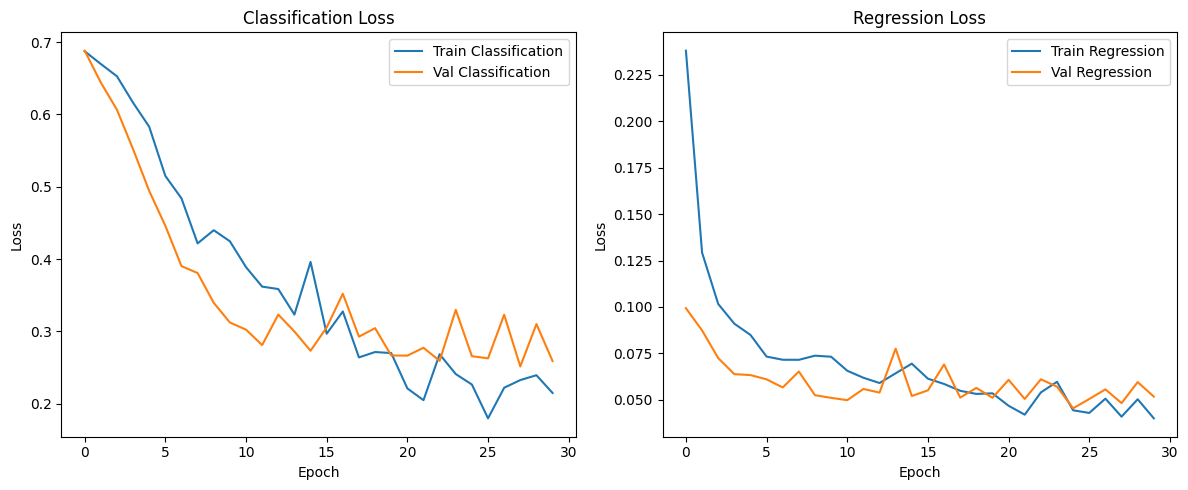

Training complete!


In [6]:
def run_training_pipeline(category_name, manual_grades_file=None):
    """
    Complete pipeline for training the multi-task model
    """
    if manual_grades_file is None:
        # If no grades file provided, use the manual grader to create one
        print("No grades file provided. Starting manual grading process...")
        grades_df = manual_grader(category_name, num_samples=10)
    else:
        # Load existing grades file
        grades_df = pd.read_csv(manual_grades_file)
        print(f"Loaded grades from {manual_grades_file}")
    
    # Data transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create dataset
    dataset = VisAGradedDataset(grades_df, transform=transform)
    
    # Split into train/validation
    train_indices, val_indices = train_test_split(
        range(len(dataset)), 
        test_size=0.2, 
        stratify=grades_df['category'],
        random_state=42
    )
    
    # Create data loaders
    train_loader = DataLoader(
        dataset, 
        batch_size=8, 
        sampler=torch.utils.data.SubsetRandomSampler(train_indices)
    )
    
    val_loader = DataLoader(
        dataset, 
        batch_size=8, 
        sampler=torch.utils.data.SubsetRandomSampler(val_indices)
    )
    
    # Initialize model
    model = MultiTaskModel(pretrained=True)

    # Freeze backbone
    model = freeze_backbone(model)
    
    # Train model
    trained_model, history = train_multitask_model(
        model, 
        train_loader, 
        val_loader, 
        num_epochs=30
    )
    
    print("Training complete!")
    return trained_model, grades_df, history

# Execute pipeline
model, grades_df, history = run_training_pipeline("candle", manual_grades_file="candle_auto_grades.csv")

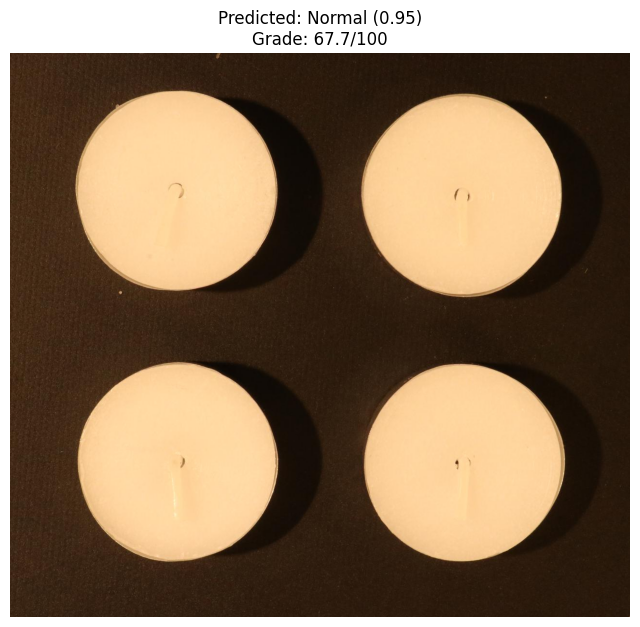

In [8]:
def predict_image_quality(model_path, image_path):
    """
    Predict category and grade for a new image
    """
    # Load model
    model = MultiTaskModel(pretrained=False)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Prepare image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        class_pred, grade_pred = model(image_tensor)
    
    # Convert to numpy for display
    class_prob = class_pred.cpu().numpy()[0][0]
    grade_score = grade_pred.cpu().numpy()[0][0] * 100  # Convert back to 0-100 scale
    
    # Determine class label
    class_label = "Normal" if class_prob > 0.5 else "Anomaly"
    
    # Display results
    plt.figure(figsize=(8, 8))
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted: {class_label} ({class_prob:.2f})\nGrade: {grade_score:.1f}/100")
    plt.axis('off')
    plt.show()
    
    return {
        'class_probability': class_prob,
        'class_label': class_label,
        'grade': grade_score
    }

# Example usage:
result = predict_image_quality("candle_best_model.pth", "/Users/josasson/Desktop/code/image_analysis_for_grading/visa_dataset/candle/Data/Images/Normal/0505.JPG")